# Translation Test Solution

Company XYZ is a worldwide e-commerce site with localized versions of the site.
A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. She therefore went and talked to the international team in charge of Spain And LatAm to see if they had any ideas about why that was happening.
Spain and LatAm country manager suggested that one reason could be translation. All Spanish- speaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.
After they run the test however, they are really surprised cause the test is negative. I.e., it appears that the non-localized translation was doing better!
You are asked to:
* Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
* Explain why that might be happening. Are the localized translations really worse?
* If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted

## Data
##### test_table : general information about test result

* user_id : the id of the user. Unique by user. Can be joined to user id in the other table. For each user, we just check whether conversion happens the first time they land on the site since the test started.
* date : when they came to the site for the first time since the test started
* source : marketing channel: Ads, SEO, Direct . Direct means everything except for ads and SEO. Such as directly typing site URL on the browser, downloading the app w/o coming from SEO or Ads, referral friend, etc.
* device : device used by the user. It can be mobile or web
* browser_language : in browser or app settings, the language chosen by the user. It can be EN, ES, Other (Other means any language except for English and Spanish) 
* ads_channel : if marketing channel is ads, this is the site where the ad was displayed. It can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn't come via an ad, this field is NA
* browser : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App, Safari, Opera
* conversion : whether the user converted (1) or not (0). This is our label. A test is considered successful if it increases the proportion of users who convert.
* test : users are randomly split into test (1) and control (0). Test users see the new translation and control the old one. For Spain-based users, this is obviously always 0 since there is no change there.

##### user_table : some information about user

* user_id : the id of the user. It can be joined to user id in the other table 
* sex : user sex: Male or Female
* age : user age (self-reported)
* country : user country based on ip address

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
import scipy.stats as st

In [6]:
test_table = pd.read_csv('/Users/YaoJunyan/Documents/A collection of Data Science take-home challenge/Spanish Translation A/Translation_Test/test_table.csv')
user_table = pd.read_csv('/Users/YaoJunyan/Documents/A collection of Data Science take-home challenge/Spanish Translation A/Translation_Test/user_table.csv')

In [7]:
test_table.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [8]:
user_table.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [9]:
test_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [10]:
user_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
user_id    452867 non-null int64
sex        452867 non-null object
age        452867 non-null int64
country    452867 non-null object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [12]:
# merge two tables
df= test_table.merge(user_table, how = 'left', on = 'user_id')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
sex                 452867 non-null object
age                 452867 non-null float64
country             452867 non-null object
dtypes: float64(1), int64(3), object(8)
memory usage: 45.0+ MB


## Question 1: Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better

In [14]:
## To answer this question, we need to conduct an A/B testing. We only need test column and conversion column

In [19]:
## Input Test Parameters and Check Sample Size is Large Enough

baseline_rate = sum(df['conversion']) / len(df['conversion'])
practical_significance = 0.01 
confidence_level = 0.05 
sensitivity = 0.8 

effect_size = sm.stats.proportion_effectsize(baseline_rate, baseline_rate + practical_significance)
sample_size = sm.stats.NormalIndPower().solve_power(effect_size = effect_size, power = sensitivity, 
                                               alpha = confidence_level, ratio=1)
print("Required sample size: ", round(sample_size), " per group")

Required sample size:  8084  per group


In [26]:
# Control group size
len(df[df['test'] == 0]['user_id'])

237338

In [27]:
# Test group size
len(df[df['test'] == 1]['user_id'])

215983

In [32]:
# Run A/B Test
#To do this we calculate a pooled probability and pooled standard error, a margin of error and the upper and lower bounds of the confidence interval.


#Calculate pooled probability
control = (df["test"] == 0)
conversions_control = df["conversion"][control].sum()
total_users_control = df["conversion"][control].count()

test = (df["test"] == 1)
conversions_treatment = df["conversion"][test].sum()
total_users_treatment = df["conversion"][test].count()

prob_pooled = (conversions_control + conversions_treatment) / (total_users_control + total_users_treatment)

print(prob_pooled)

0.04957855471067963


In [38]:
#Calculate pooled standard error and margin of error
se_pooled = math.sqrt(prob_pooled * (1 - prob_pooled) * (1 / total_users_control + 1 / total_users_treatment))
z_score = st.norm.ppf(1 - confidence_level / 2)
margin_of_error = se_pooled * z_score

#Calculate dhat, the estimated difference between probability of conversions in the experiment and control groups
d_hat = (conversions_treatment / total_users_treatment) - (conversions_control / total_users_control)

#Test if we can reject the null hypothesis
lower_bound = d_hat - margin_of_error
upper_bound = d_hat + margin_of_error

In [39]:
if practical_significance < lower_bound:
    print("Reject null hypothesis")
else: 
    print("Do not reject the null hypothesis")
    
print("The lower bound of the confidence interval is ", round(lower_bound * 100, 2), "%")
print("The upper bound of the confidence interval is ", round(upper_bound * 100, 2), "%")


Do not reject the null hypothesis
The lower bound of the confidence interval is  -1.3 %
The upper bound of the confidence interval is  -1.05 %


## Improvement/ Revise

In [40]:
## Check if the data distribution is the same for control and test group

Text(0.5, 1.0, 'the number of users in each country for two groups')

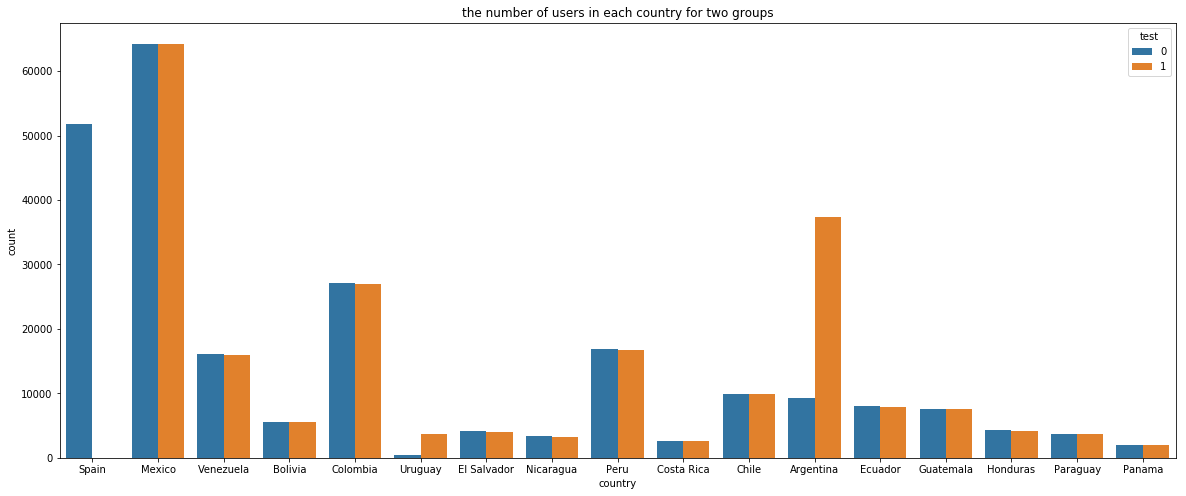

In [43]:
fig, ax= plt.subplots(figsize =(20,8))
sns.countplot(x= 'country', hue='test', data= df)
ax.set_title('the number of users in each country for two groups')

#### Clearly the test and control groups are not evenly distribution for the test and control group for countries like Spain, Urugay, and Argentina; We might want to exclude these countries from our tests

Text(0.5, 1.0, 'the number of users from each source for two groups')

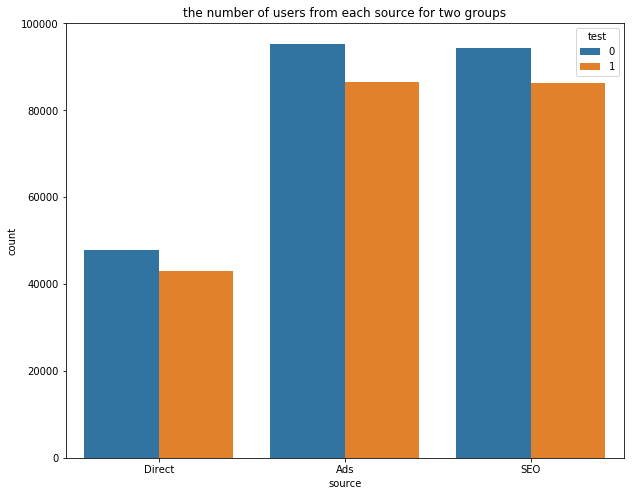

In [47]:
fig, ax= plt.subplots(figsize =(10,8))
sns.countplot(x= 'source', hue='test', data= df)
ax.set_title('the number of users from each source for two groups')

#### Distributions for control and test in this column is roughly the same

Text(0.5, 1.0, 'the number of users using each device for two groups')

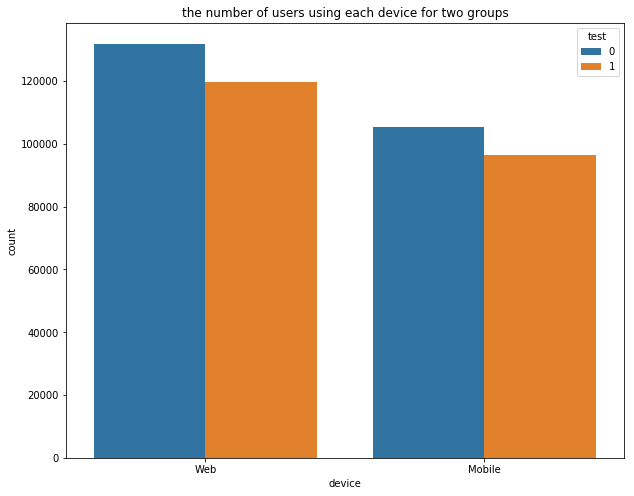

In [49]:
fig, ax= plt.subplots(figsize =(10,8))
sns.countplot(x= 'device', hue='test', data= df)
ax.set_title('the number of users using each device for two groups')

#### the distribution for this column is not the same, but ok

Text(0.5, 1.0, 'the number of users from differnt ads channel for two groups')

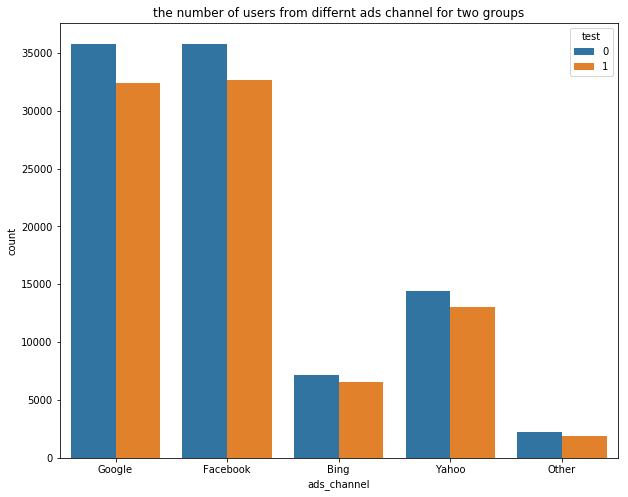

In [52]:
fig, ax= plt.subplots(figsize =(10,8))
sns.countplot(x= 'ads_channel', hue='test', data= df)
ax.set_title('the number of users from differnt ads channel for two groups')

#### the distribution for this column is not the same, but ok

Text(0.5, 1.0, 'the number of users using different browser for two groups')

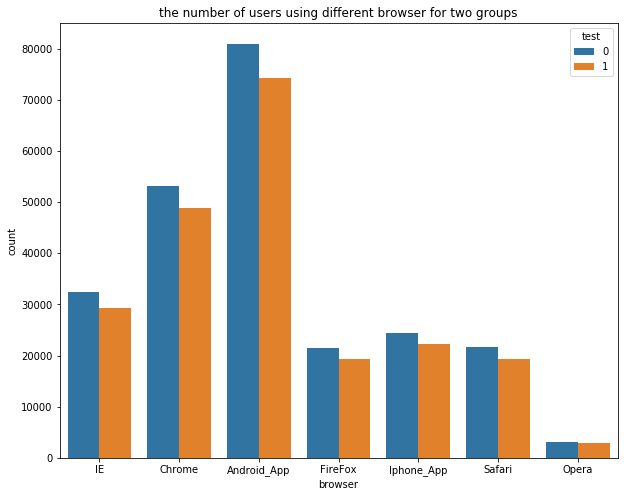

In [54]:
fig, ax= plt.subplots(figsize =(10,8))
sns.countplot(x= 'browser', hue='test', data= df)
ax.set_title('the number of users using different browser for two groups')

#### the distribution for this column is not the same, but ok

Text(0.5, 1.0, 'sex of users for two groups')

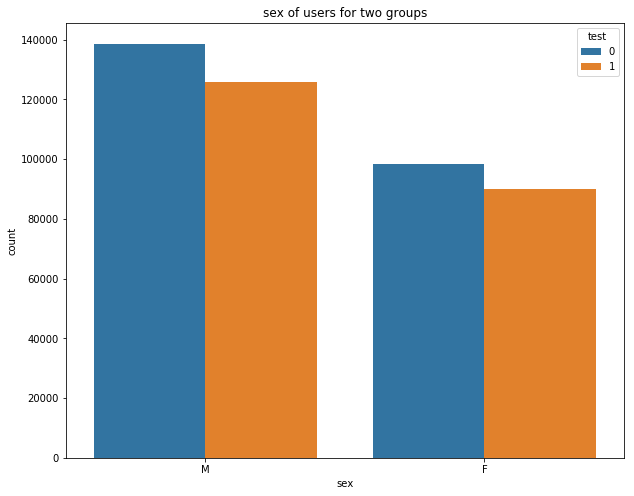

In [55]:
fig, ax= plt.subplots(figsize =(10,8))
sns.countplot(x= 'sex', hue='test', data= df)
ax.set_title('sex of users for two groups')

#### the distribution for this column is not the same, but ok

Text(0.5, 1.0, 'sex of users for two groups')

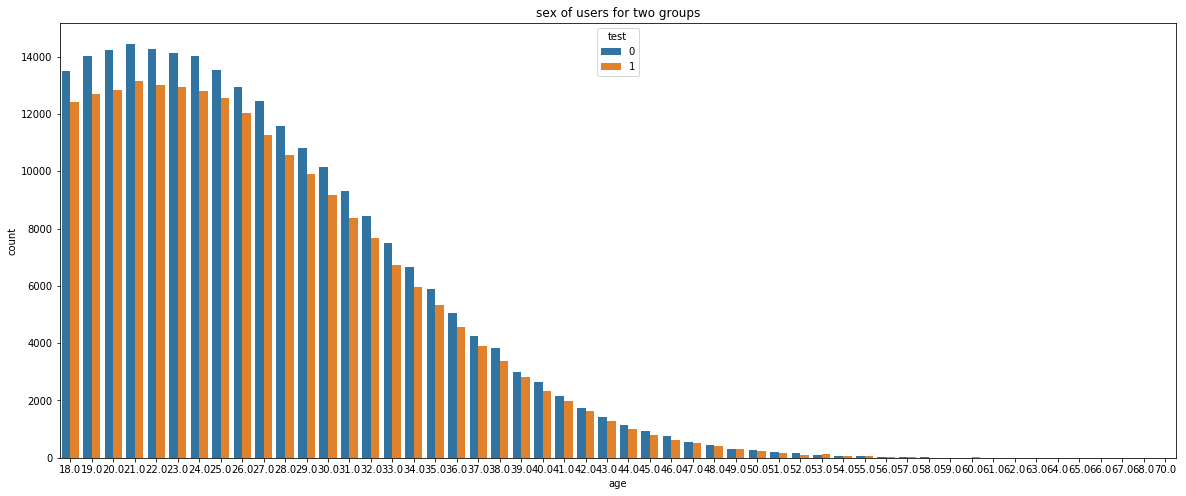

In [57]:
fig, ax= plt.subplots(figsize =(20,8))
sns.countplot(x= 'age', hue='test', data= df)
ax.set_title('sex of users for two groups')

## Let's test without country Spain, Urugay, and Argentina

In [59]:
exclude= ['Spain', 'Argentina', 'Uruguay']

In [63]:
new_df= df[~df.country.isin(exclude)]

In [65]:

#Calculate pooled probability
control = ( new_df["test"] == 0)
conversions_control = new_df["conversion"][control].sum()
total_users_control = new_df["conversion"][control].count()

test = (new_df["test"] == 1)
conversions_treatment = new_df["conversion"][test].sum()
total_users_treatment = new_df["conversion"][test].count()

prob_pooled = (conversions_control + conversions_treatment) / (total_users_control + total_users_treatment)

print(prob_pooled)

0.050303417438518044


In [66]:
#Calculate pooled standard error and margin of error
se_pooled = math.sqrt(prob_pooled * (1 - prob_pooled) * (1 / total_users_control + 1 / total_users_treatment))
z_score = st.norm.ppf(1 - confidence_level / 2)
margin_of_error = se_pooled * z_score

#Calculate dhat, the estimated difference between probability of conversions in the experiment and control groups
d_hat = (conversions_treatment / total_users_treatment) - (conversions_control / total_users_control)

#Test if we can reject the null hypothesis
lower_bound = d_hat - margin_of_error
upper_bound = d_hat + margin_of_error

In [67]:
if practical_significance < lower_bound:
    print("Reject null hypothesis")
else: 
    print("Do not reject the null hypothesis")
    
print("The lower bound of the confidence interval is ", round(lower_bound * 100, 2), "%")
print("The upper bound of the confidence interval is ", round(upper_bound * 100, 2), "%")


Do not reject the null hypothesis
The lower bound of the confidence interval is  -0.12 %
The upper bound of the confidence interval is  0.17 %


In [69]:
## more to-do: check test for each country

## Conclusion:

 Not a great success given that the goal was to improve conversion rate, but at least we know that a localized translation didn’t make things worse!